# ワランティ分析サンプル
公開されている過去の不具合データを利用して Knowledge Graph の構築を行います。

## データの準備
[国土交通省の HP](https://carinf.mlit.go.jp/jidosha/carinf/ris/index.html) のクレームデータから適当にサンプルしたデータを利用します。

In [1]:
import os, random, datetime
import numpy as np
import pandas as pd

df = pd.read_csv("../data/raw/recall_sample.csv")
df.columns = ['id','part','cause','measure']

In [2]:
# データの確認
df.head()

,id,part,cause,measure
0,4647,原動機（ターボチャージャー）,４Ｖ２０型エンジンを搭載した中型トラックにおいて、ターボチャージャー取付けナットの締付け作業...,全車両、ターボチャージャー取付けナットを正規トルクで締付ける。
1,4667,車両全長,フォークリフトにおいて、受注時の作業装置（フォーク等）の仕様組み合わせに伴う法規適合確認が不...,全車両、小型特殊自動車の長さ要件を満足する作業装置（フォーク等）と交換する。
2,4667,方向指示器,フォークリフト等において、受注時の作業装置（フォーク等）の仕様組み合わせに伴う法規適合確認が...,全車両、保安基準に満足するよう方向指示器を適切な位置に変更又は作業装置（フォーク等）を交換する。
3,4659,エアバッグ装置（インフレーター）,運転者席用エアバッグのインフレーター(膨張装置)において、吸湿防止が不適切なため、ガス発生剤...,全車両、予防的措置としてエアバッグインフレーターを代替品と交換する。なお、部品が準備でき次第...
4,4660,エアバック装置（インフレーター）,大型トラック・小型バスの運転者席用エアバッグのインフレータ（膨張装置）において、吸湿防止が不...,全車両、運転者席用エアバッグ装置の有無を確認し、装着されていた場合は、予防的措置としてエアバ...


## Azure Text Analytics によるキーフレーズの抽出
Azure Cognitive Services の Text Analytics サービスを利用して、テキスト文章からキーフレーズを抽出します。本番プロジェクトでは、業務要件に応じて、ユーザ固有のキーフレーズへの対応が必要の場合があるのでご注意ください。

In [3]:
# Azure Text Analytics　の key と Endpoint の情報を入力
key = '' # ご自身のKeyを''内に入力ください
endpoint = '' # ご自身のEndpointを''内に入力ください

## クライアント認証
ドキュメントに記載されている Python の[クイックスタート](https://docs.microsoft.com/ja-jp/azure/cognitive-services/text-analytics/quickstarts/text-analytics-sdk?pivots=programming-language-python&tabs=version-3#sentiment-analysis)に実装していきます。

In [4]:
from azure.ai.textanalytics import TextAnalyticsClient
from azure.core.credentials import AzureKeyCredential

def authenticate_client():
    ta_credential = AzureKeyCredential(key)
    text_analytics_client = TextAnalyticsClient(
            endpoint=endpoint, credential=ta_credential)
    return text_analytics_client

client = authenticate_client()

## キーフレーズ抽出
キーフレーズを抽出するメソッドを作成します。キーフレーズとして利用したく無いワードがある場合は、`stop_words` にて定義しておきます。

In [5]:
# インプットされたテキストからキーフレーズを抽出
def key_phrase_extraction(text):
    key_p = []
    try:
        documents = text
        # 日本語としてキーフレーズを抽出 (language = "ja" )
        response = client.extract_key_phrases(documents = documents, language = "ja")[0]

        if not response.is_error:
            for phrase in response.key_phrases:
                if phrase == phrase[0]:
                    key_p=[phrase]
                else:
                    key_p.append(phrase)

    except Exception as err:
        print("Encountered exception. {}".format(err))
    
    # 除外したいワードのリスト
    stop_words = [ 'ため', '改め', 'イン', 'おい', '認め', '場合', '対策品', '車両', 'もの', '使用', \
                '発生', '交換', '位置', '新品', '確認', '対策仕様', '良品', '保安基準', '装着', 'バス', '大型トラック','']
    key_p_without_stop = [word for word in key_p if word not in stop_words]


    return key_p_without_stop

In [6]:
# Text Analytics んが正常に動作するか試す
key_phrase_extraction(["私はサッカーが好きです"])

['サッカー']

In [7]:
# 不具合の部位、原因, measure のそれぞれに対してキーフレーズ抽出し、タグ (不具合部位(パーツ): p, 原因:c, 対策:m) を付与する
key_list =  []
key_tmp = {}
part_key_list, cause_key_list, measure_key_list = [],[],[]
part_list = df["part"].to_list()
cause_list = df["cause"].to_list()
measure_list = df["measure"].to_list()

# 各クレームデータごとに「不具合の部位」「原因」「対策」からキーフレーズを抽出し、key_list に格納する
for i, (part_list, cause_txt, measure_txt) in enumerate(zip(part_list, cause_list, measure_list)):  
    key_tmp = []
    part_key_phrase = part_list  # 不具合の部位 -> 単一のワード
    cause_key_phrases = key_phrase_extraction([cause_txt])  # 原因 -> List 型
    measure_key_phrases = key_phrase_extraction([measure_txt])  # 対策 -> List 型
    
    # key_list にキーフレーズを追加していく
    key_tmp.append((part_key_phrase, "不具合の部位"))  # 不具合部位
    for c in cause_key_phrases:  # 原因
        key_tmp.append((c, "原因"))
    for m in measure_key_phrases: # 対策
        key_tmp.append((m, "対策"))
    key_list.append(key_tmp)


# Knowledge Graph の構築
キーフレーズを Node、共起の回数を Edge としたグラフネットワーク

### データ準備
キーフレーズの出現回数をカウントします。Node の大きさを表すのに利用します。

In [8]:
import requests
import json
import collections
import itertools
import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt
import japanize_matplotlib
from matplotlib import font_manager
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']

/anaconda/envs/warranty/lib/python3.6/site-packages/japanize_matplotlib/japanize_matplotlib.py:15: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [9]:
from collections import defaultdict
counter_dict = defaultdict(int)  # default は 0

In [10]:
for keys in key_list:
    for key in keys:
        counter_dict[key] += 1

In [11]:
counter_df = pd.DataFrame(columns=["key-label", "key", "label", "count"])
for i, j in enumerate(counter_dict.items()):
    counter_df.loc[i, "key-label"] = j[0]
    counter_df.loc[i, "key"] = j[0][0]
    counter_df.loc[i, "label"] = j[0][1]
    counter_df.loc[i, "count"] = j[1]

In [12]:
# 「原因」「対策」は、出現回数が 2 回以上のキーフレーズに限定
counter_df = counter_df[((counter_df["count"] > 1) & (counter_df["label"] =="対策")) |  ((counter_df["count"] > 1) & (counter_df["label"] =="原因")) | (counter_df["label"]=="不具合の部位")]

In [13]:
counter_df.head()

,key-label,key,label,count
0,"(原動機（ターボチャージャー）, 不具合の部位)",原動機（ターボチャージャー）,不具合の部位,1
4,"(漏れ, 原因)",漏れ,原因,2
7,"(異音, 原因)",異音,原因,2
12,"(車両全長, 不具合の部位)",車両全長,不具合の部位,1
14,"(受注時, 原因)",受注時,原因,2


### Networkx によるグラフデータの可視化

In [14]:
G = nx.Graph()
# Node 作成
G.add_nodes_from([(keylabel, {"count":count}) for keylabel, count in zip(counter_df['key-label'], counter_df['count'])])

In [15]:
# 各クレームデータごとに、キーフレーズの組み合わせが何回同時に出現するかをカウント (weight)
for tags in key_list:
    for tag0, tag1 in itertools.combinations(tags, 2):
        if not G.has_node(tag0) or not G.has_node(tag1):
            continue
        if G.has_edge(tag0, tag1): # 共起があったので weight を増やす
            G[tag0][tag1]["weight"] += 1
        else: # 新しい共起のリレーション
            G.add_edge(tag0, tag1, weight=1)

In [16]:
# networkx でノードのラベルを表示するときに参照する dict
labels = {}
for (i,j) in G.nodes(data=True):
    labels[i] = i[0]

In [17]:
colors = {"不具合の部位": "gray", "原因": "red", "対策": "blue"}

In [18]:
edge_width = [d['weight'] * 1.0 for (u,v,d) in G.edges(data=True)] 
node_color = [colors[i[1]] for i,j in G.nodes(data=True)] 
node_size  = [j["count"] * 500 for i,j in G.nodes(data=True)] 

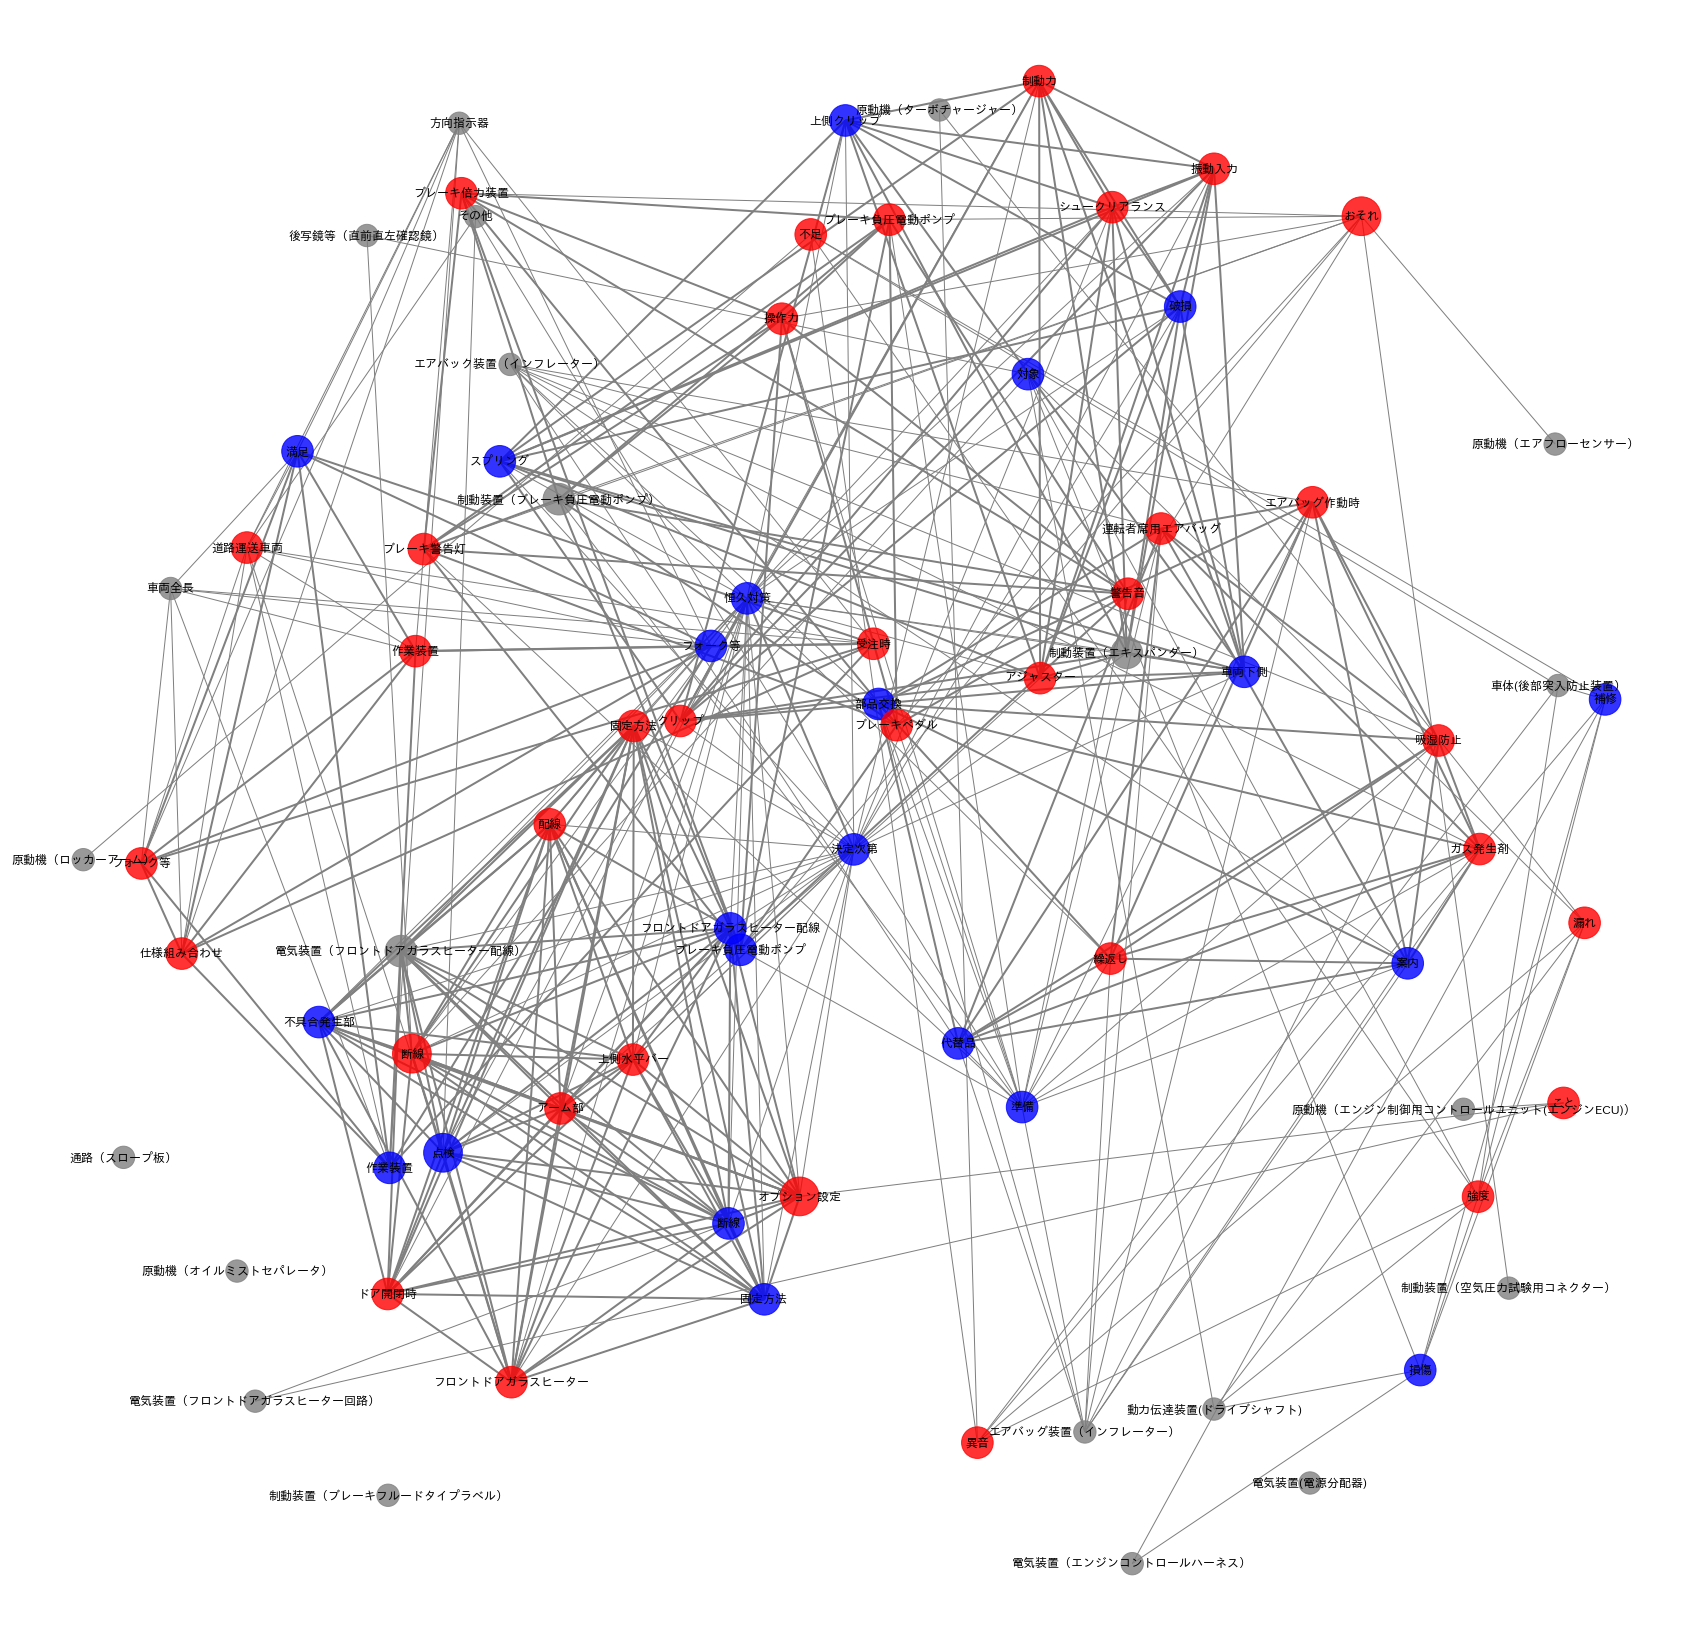

In [19]:
pos = nx.spring_layout(G, k=1.5) # ノード間の反発力を定義。値が小さいほど密集
plt.figure(figsize=(30,30)) 
nx.draw_networkx_edges(G, pos, alpha=1.0, edge_color='gray', width=edge_width)
nx.draw_networkx_labels(G, pos, labels = labels)
nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=node_size, alpha=0.8) # ノードのスタイルを定義
plt.axis('off')
plt.show()

### Power BI 可視化用のデータ作成 (Word Cloud, Network Navigator)
Power BI の Word Cloud と Network Navigator ビジュアルを利用してワードやグラフデータを可視化します。ここではインプットとなる CSV データを作成します。

#### Word Cloud

In [20]:
counter_df.to_csv("../data/processed/node_master.csv", header=True)

#### Network Navigator

In [21]:
# key-label の組み合わせから、出現回数 (カウント) を返すメソッド
def get_count(keylabel):
    return counter_df[counter_df["key-label"] == keylabel]["count"]

In [22]:
lists = []
for (i, j, d) in G.edges(data=True):
    tmp = [i, i[0], i[1], colors[i[1]], get_count(i).values[0]*10, j, j[0], j[1], colors[j[1]], get_count(j).values[0]*10, d['weight']]
    lists.append(tmp)

In [23]:
columns = ["source_origin", "source", "source_attr", "source_color", "source_count", "target_origin", "target", "target_attr", "target_color", "target_count","edge_weight"]
pbi_df = pd.DataFrame(lists, columns=columns)

In [24]:
# CSV ファイルとして出力s
pbi_df.to_csv("../data/processed/pbi_df.csv", header=True)